In [1]:
import os
import numpy as np
import seaborn as sns
import librosa
import shutil
from io import BytesIO
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-30 14:12:42.473375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 14:12:42.473492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 14:12:42.609171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:

data_path = '/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset'
data = []   
labels = []  
categories = os.listdir(data_path) 
for category in categories:
    print(category)
    category_path = os.path.join(data_path, category) 
    
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name) 
        img = load_img(img_path, target_size=(100, 100)) 
        img_array = img_to_array(img) 
        img_array /= 255.0  
        data.append(img_array) 
        labels.append(category)


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)
X_train, X_test, y_train, y_test = train_test_split(data, categorical_labels, test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5, random_state=42)
additional_augmented_data = []
additional_augmented_labels = []
counter=0
for img, label in zip(X_train, y_train):
    print(counter+1)
    augmented_img = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.4,
        zoom_range=0.4,
        horizontal_flip=True,
        fill_mode='nearest'
    ).random_transform(img)
    additional_augmented_data.append(augmented_img)
    additional_augmented_labels.append(label)
X_train = np.concatenate((X_train, additional_augmented_data), axis=0)
y_train = np.concatenate((y_train, additional_augmented_labels), axis=0)

In [6]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')
print(f'y_test shape is {y_test.shape}')

X_train shape is (12568, 100, 100, 3)
X_val shape is (786, 100, 100, 3)
X_test shape is (786, 100, 100, 3)
y_train shape is (12568, 31)
y_val shape is (786, 31)
y_test shape is (786, 31)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

input_shape = (100, 100, 3)
num_classes = 31

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential([
    base_model,
    Flatten(),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(num_classes, activation='softmax')  
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print(model.summary())

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



/tmp/ipykernel_151/1852111584.py:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1604 - loss: 3.0427

W0000 00:00:1732978392.149858     213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


393/393 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.1607 - loss: 3.0415 - val_accuracy: 0.5954 - val_loss: 1.3914
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5579 - loss: 1.4664 - val_accuracy: 0.7366 - val_loss: 0.9464
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6926 - loss: 1.0088 - val_accuracy: 0.7875 - val_loss: 0.7851
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7669 - loss: 0.7633 - val_accuracy: 0.8359 - val_loss: 0.5727
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7927 - loss: 0.6861 - val_accuracy: 0.8651 - val_loss: 0.5434
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8349 - loss: 0.5642 - val_accuracy: 0.8931 - val_loss: 0.4117
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8507 - loss: 0.5032 - val_accuracy: 0.8842 - val_loss: 0.4463
Epoch 8/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8560 - loss: 0.4722 - val_accurac

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step


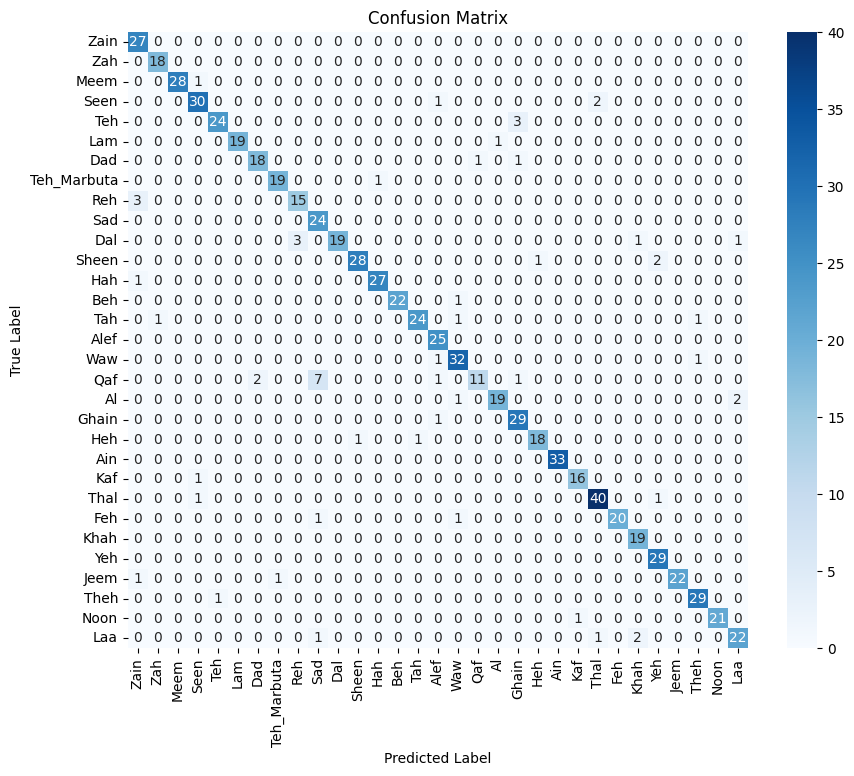


Classification Report:
              precision    recall  f1-score   support

        Zain       0.84      1.00      0.92        27
         Zah       0.95      1.00      0.97        18
        Meem       1.00      0.97      0.98        29
        Seen       0.91      0.91      0.91        33
         Teh       0.96      0.89      0.92        27
         Lam       1.00      0.95      0.97        20
         Dad       0.90      0.90      0.90        20
 Teh_Marbuta       0.95      0.95      0.95        20
         Reh       0.83      0.83      0.83        18
         Sad       0.73      1.00      0.84        24
         Dal       1.00      0.79      0.88        24
       Sheen       0.97      0.90      0.93        31
         Hah       0.96      0.96      0.96        28
         Beh       1.00      0.96      0.98        23
         Tah       0.96      0.89      0.92        27
        Alef       0.86      1.00      0.93        25
         Waw       0.89      0.94      0.91        34
   

In [ ]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import os


data_path = '/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset'


label_encoder = LabelEncoder()
categories = os.listdir(data_path)
label_encoder.fit(categories)

def predict_image(image_path, model, label_encoder):
    
    img = load_img(image_path, target_size=(100, 100))  
    img_array = img_to_array(img)  
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  

    
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    print(predicted_class_index)
    
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
    
    return predicted_label


test_image_path = '/kaggle/input/test-letter-alef/WhatsApp Image 2024-11-30 at 12.17.55 PM.jpeg'


predicted_label = predict_image(test_image_path, model, label_encoder)

print(f"The predicted label for the image is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4
The predicted label for the image is: Dad
